# Regularized Regression Models

## Ridge Regression

In [62]:
"""modules"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from copy import deepcopy
from sklearn.metrics import mean_squared_error

In [63]:
"""noisy dataset"""
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

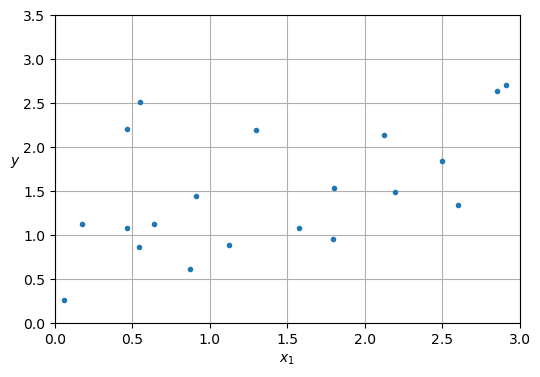

In [64]:
"""plot the data"""
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [65]:
"""fit the ridge regression"""
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

In [66]:
"""function to plot model for different alpha"""

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

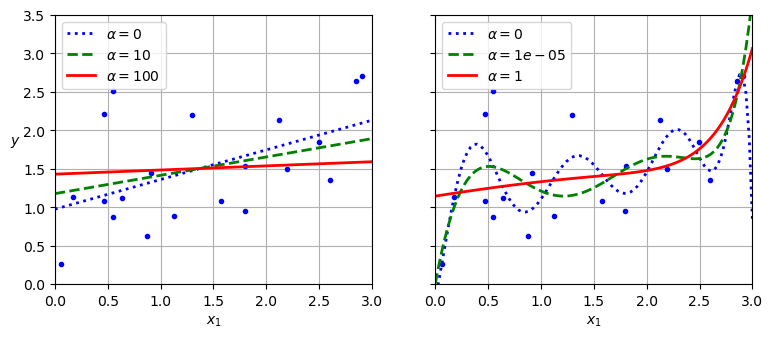

In [67]:
"""using the above function"""
plt.figure(figsize=(9, 3.5))
plt.subplot(121) # first plot 
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122) # second plot
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

In [68]:
"""fit stochastic gradient descent regressor"""
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

In [69]:
"""get roughly the same solution as earlier when we use Stochastic Average GD (solver="sag")"""
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

In [70]:
"""closed form Ridge regression, compare with Ridge model's learned from parameters"""
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [71]:
ridge_reg.intercept_, ridge_reg.coef_  # extra code

(array([0.97896386]), array([[0.38286422]]))

## Lasso Regression

In [72]:
"""fit the lasso model"""
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

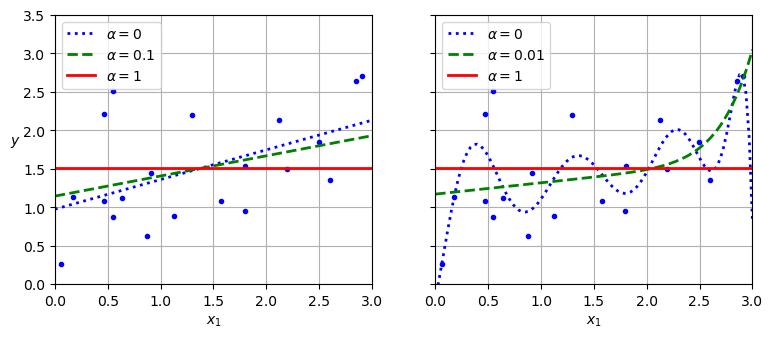

In [73]:
"""using the previous plot_model function for lasso"""
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

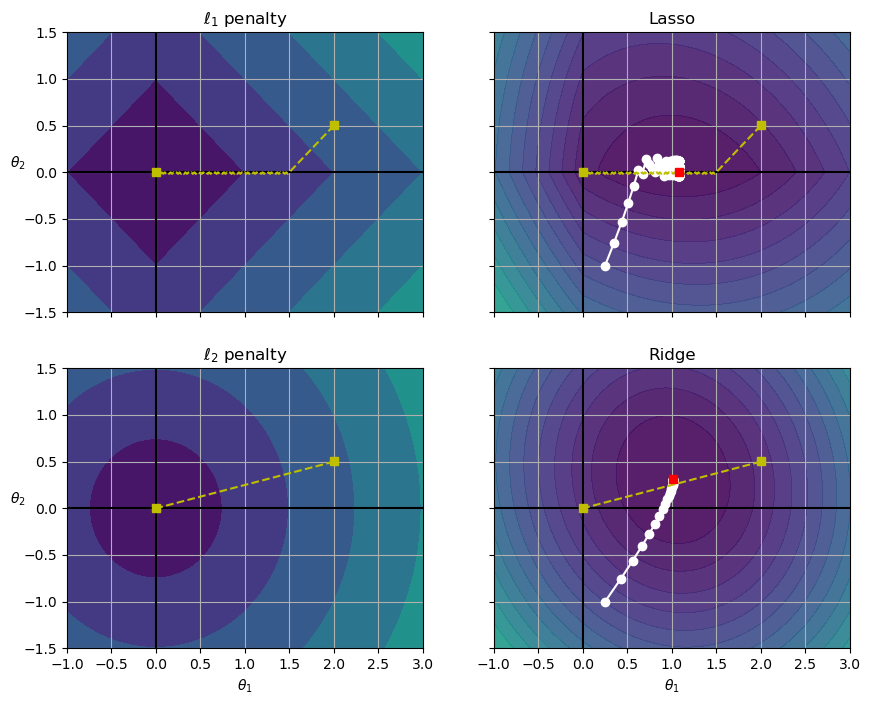

In [74]:
"""show the difference between Ridge and Lasso"""

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

"""function to gain the learning curve"""
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


"""plot the outcome"""
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
plt.show()

## Elastic Net

In [75]:
"""fit and predict the model"""
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

In [76]:
"""quadratic dataset"""
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

In [77]:
"""make the pipeline"""
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())

In [78]:
"""process the data and parameters"""
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')

In [79]:
"""calculate the training and validation error"""
train_errors, val_errors = [], []

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)


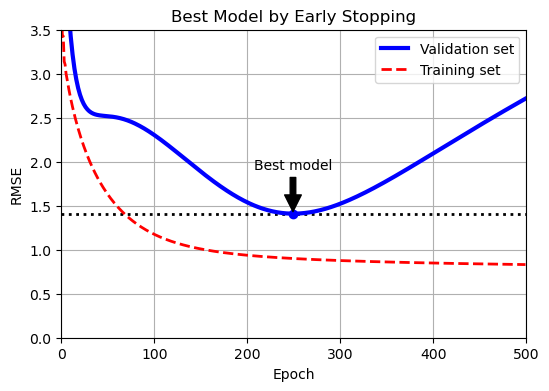

In [80]:
"""plot the best model gained by early stopping"""
best_epoch = np.argmin(val_errors) # for the best validation error
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Best Model by Early Stopping")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

**Outcome:** we know exactly at what epoch our model gets best results.